In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

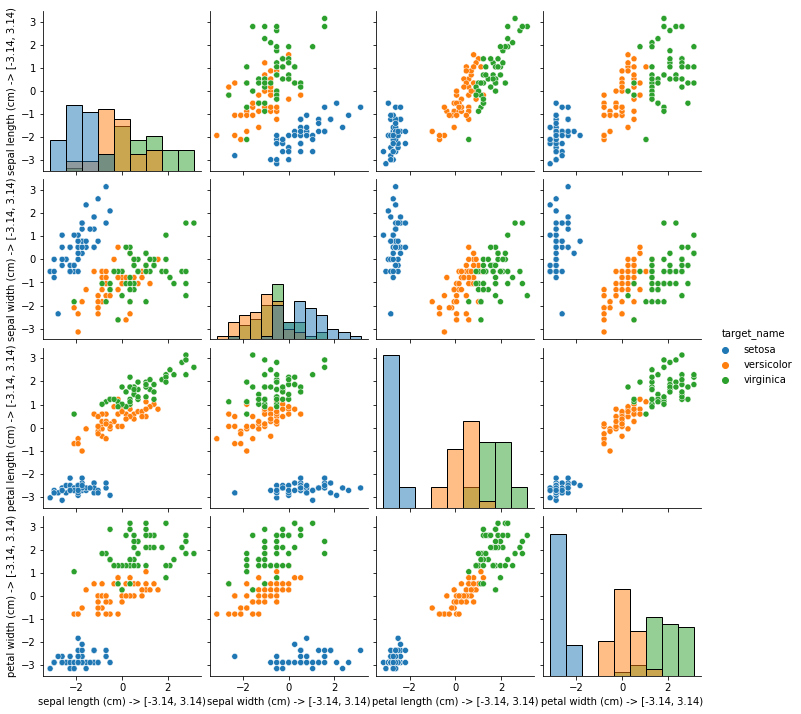

In [3]:
from classifiers.quantum.qasvm import PseudoNormQSVM
from classifiers.datasets import IrisDataset

ds = IrisDataset(feature_range=(-np.pi, np.pi))
ds.plot()

<BarContainer object of 150 artists>

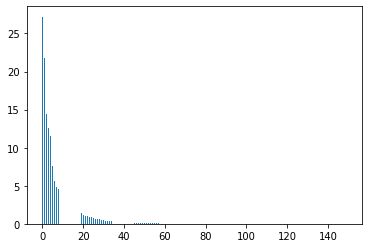

In [4]:
from classifiers.quantum.ansatz import Circuit9
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap

M=150
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
X, y = ds.data, ds.target
X, y = ds.sample(M, return_X_y=True)
ind = np.argsort(y)
X, y = X[ind], y[ind]
X = X[:, :]


feature_map1 = Circuit9(X.shape[1], reps=1)
feature_map = feature_map1.copy()
for _ in range(2 - 1):
    feature_map.compose(feature_map1, inplace=True)

#feature_map = ZZFeatureMap(4, 2, entanglement='linear')
gamma = 0.9
def RBF(x, y):
    return np.exp(-np.linalg.norm(x-y)**2/2/gamma)

def make_kmatrix(X, Y, f):
    ret = []
    for x in X:
        tmp = []
        for y in Y:
            tmp.append(f(x, y))
        ret.append(tmp)
    return np.matrix(ret)

quantum_instance = QuantumInstance(backend=AerSimulator(method='statevector'), shots=2**13)
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance, enforce_psd=True)
kernel_matrix = quantum_kernel.evaluate(x_vec=X)
# kernel_matrix =  make_kmatrix(X, X, RBF)
eigs = np.abs(np.linalg.eigvals(kernel_matrix))
plt.bar(np.arange(M), sorted(eigs, key=lambda x: -x), 0.3)

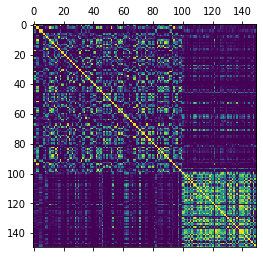

In [5]:
plt.matshow(kernel_matrix)

1.0


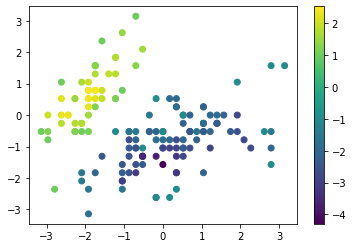

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(C=10**10, kernel='precomputed')
svm.fit(kernel_matrix, y)
c = svm.decision_function(kernel_matrix)
print(accuracy_score(y, svm.predict(kernel_matrix)))
plt.scatter(X[:,0], X[:, 1], c=c)
plt.colorbar()

In [7]:
from scipy.optimize import minimize

def func(x):
    return x.T @ np.kron([[-1, 1], [1, -1]], kernel_matrix) @ x

def lin_const(x):
    return np.kron(np.eye(2), np.ones(M)) @ x - np.ones(2).T

sol = minimize(fun=func, x0=np.random.rand(2*M), bounds=[(0, None) for _ in range(2*M)], constraints=dict(type='eq', fun=lin_const))
if sol.success:
    alpha = sol.x[:M]
    beta = sol.x[M:]

0.3


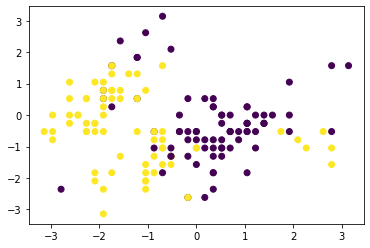

In [8]:
cluster_ind = (alpha.T @ kernel_matrix @ alpha - beta.T @ kernel_matrix @ beta)/2 <= kernel_matrix @ (alpha - beta)
plt.scatter(X[:, 0], X[:, 1], c=cluster_ind)
error_rate = sum(cluster_ind!=y)/len(y)
print(error_rate)

In [9]:
class MyClustering():
    def __init__(self, kernel):
        self.kernel = kernel
        self.m = kernel.shape[0]

    def ramdom_sampling(self):
        return np.random.choice(self.m, int(self.m/2))
    

In [10]:
from cvxopt import matrix, solvers
M = kernel_matrix.shape[0]
P = matrix(kernel_matrix)
q = matrix(np.zeros(M))
G = matrix(-np.eye(M))
h = matrix(np.zeros(M))
A = matrix(np.ones(M), (1, M))
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)
dval = 2*sol['primal objective']
alpha = sol['x']

     pcost       dcost       gap    pres   dres
 0:  5.1501e-02 -9.7179e-01  2e+02  1e+01  1e+01
 1:  6.1195e-02 -9.5093e-01  3e+00  1e-01  1e-01
 2:  6.8278e-02 -3.0979e-01  4e-01  2e-16  4e-15
 3:  6.4658e-02 -3.5763e-03  7e-02  5e-17  2e-15
 4:  5.5500e-02  2.8264e-02  3e-02  2e-16  4e-16
 5:  5.2417e-02  4.6020e-02  6e-03  4e-17  3e-16
 6:  5.0129e-02  4.8375e-02  2e-03  3e-16  2e-16
 7:  4.9341e-02  4.9042e-02  3e-04  2e-16  2e-16
 8:  4.9170e-02  4.9159e-02  1e-05  3e-16  2e-16
 9:  4.9163e-02  4.9162e-02  3e-07  5e-16  2e-16
10:  4.9162e-02  4.9162e-02  1e-08  7e-16  2e-16
Optimal solution found.


In [11]:
R2 = 1-dval

In [12]:
sv_ind = np.isclose(np.asarray(1-2*alpha.H*P + dval)[0], R2)
def radious2(x):
    return np.asarray(1-2*matrix(np.asarray(alpha)[sv_ind]).H*matrix(quantum_kernel.evaluate(X[sv_ind], x))+dval)[0]

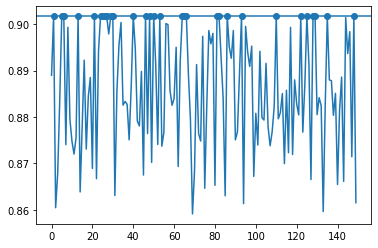

In [13]:
plt.plot(np.asarray(1-2*alpha.H*P + dval)[0])
plt.axhline(y=R2, xmin=0, xmax=M-1)
plt.scatter(np.where(sv_ind), np.asarray(1-2*alpha.H*P + dval)[0][sv_ind])

In [14]:
A = np.empty_like(kernel_matrix)
from itertools import product
from tqdm.notebook import tqdm
for i, j in tqdm(list(product(range(M), range(M)))):
    if i==j:
        A[i, j]=1
    elif i>j:
        tX = np.asanyarray([t*X[i]+(1-t)*X[j] for t in np.linspace(0, 1, 20)])
        ind = radious2(tX)
        if np.any(ind>R2):
            A[i, j]=0
            A[j, i]=0
        else:
            A[i, j]=1
            A[j, i]=1
    else:
        pass
A

  0%|          | 0/22500 [00:00<?, ?it/s]

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

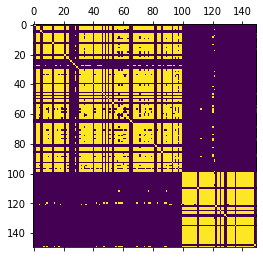

In [15]:
plt.matshow(A)

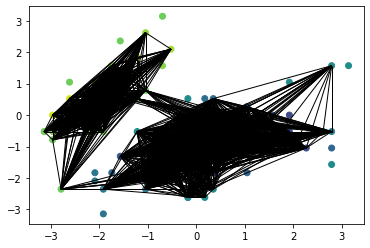

In [16]:
import networkx as nx 
G = nx.from_numpy_matrix(A)
positions = dict(zip(G.nodes, X[:, :2]))

ax = plt.subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=c)
nx.draw_networkx_edges(G, positions, ax=ax)

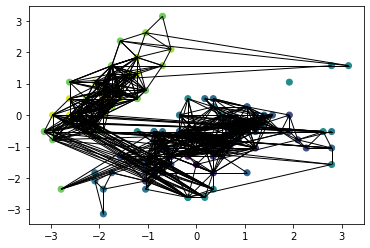

In [17]:
K2 = (kernel_matrix.flatten()>1-1/2*R2).reshape(M, M)
G = nx.from_numpy_matrix(K2)
positions = dict(zip(G.nodes, X[:, :2]))

ax = plt.subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=c)
nx.draw_networkx_edges(G, positions, ax=ax)

In [18]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2, affinity='precomputed')
sc.fit(kernel_matrix)

SpectralClustering(affinity='precomputed', n_clusters=2)

In [19]:
sc.fit_predict(kernel_matrix)

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

0.19333333333333333


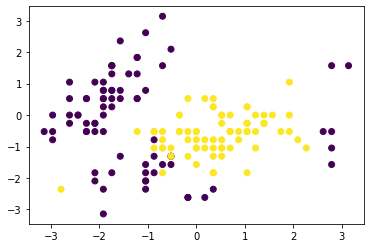

In [20]:
ax = plt.subplot(1, 1, 1)
sc_cluster_label = sc.fit_predict(kernel_matrix)
ax.scatter(X[:, 0], X[:, 1], c=sc_cluster_label)
print(min(sum(sc_cluster_label != y)/len(y), sum(sc_cluster_label == y)/len(y)))

In [21]:
refA = np.empty_like(kernel_matrix)
for i, j in list(product(range(M), range(M))):
    if i==j:
        refA[i, j]=1
    elif i>j:
        if y[i]!=y[j]:
            refA[i, j]=0
            refA[j, i]=0
        else:
            refA[i, j]=1
            refA[j, i]=1
    else:
        pass
refA

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

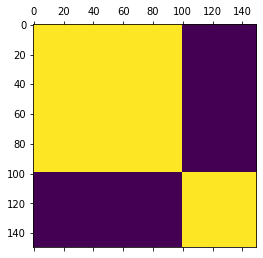

In [22]:
plt.matshow(refA)

In [23]:
def adj_error(mat, ref):
    return np.linalg.norm(mat-ref, ord=None)/np.linalg.norm(np.ones_like(ref), ord=None)